# **Image classification**

This Google colab contains the code for transfer learning, in which at first stage pre-trained architectures (trained on different dataset) are used for building model and this model is used for making prediction for the new dataset. In the second stage, model built with these architectures are trained (excluding base model/architectures) for the current dataset and then used for making predictions. The whole idea is to use the learning of these architectures on the current dataset.   

# Downloading the data from Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
# Deleting old data folder, if its there
%rm -rf chest_x-ray_data 

In [ ]:
# Uploading json file
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Creating directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading the data
! kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [00:39<00:00, 73.8MB/s]
100% 2.06G/2.06G [00:39<00:00, 56.0MB/s]


In [ ]:
# Un-zip the data to folder
! mkdir chest_x-ray_data
! unzip chest-xray-covid19-pneumonia.zip -d chest_x-ray_data

Streaming output truncated to the last 5000 lines.
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(228).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(229).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(23).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(230).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(231).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(232).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(233).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(234).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(235).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(236).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(237).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(238).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(239).jpg  
  inflating: chest_x-ray_data/Data/train/COVID19/COVID19(24).jpg  

# Importing required libraries

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
import os
import warnings
from tensorflow.random import set_seed
warnings.filterwarnings("ignore")

# Data visualisation

In [ ]:
# Creating paths for the data
train_NORMAL = "chest_x-ray_data/Data/train/NORMAL"
train_PNEUMONIA = "chest_x-ray_data/Data/train/PNEUMONIA"
train_COVID19 = "chest_x-ray_data/Data/train/COVID19"

test_NORMAL = "chest_x-ray_data/Data/test/NORMAL"
test_PNEUMONIA = "chest_x-ray_data/Data/test/PNEUMONIA"
test_COVID19 = "chest_x-ray_data/Data/test/COVID19"

In [ ]:
# Printing the number of data for each class, in both train and test folders
print("train_NORMAL: ", len(os.listdir(train_NORMAL)))
print("train_PNEUMONIA: ", len(os.listdir(train_PNEUMONIA)))
print("train_COVID19: ", len(os.listdir(train_COVID19)))
print("test_NORMAL: ", len(os.listdir(test_NORMAL)))
print("test_PNEUMONIA: ", len(os.listdir(test_PNEUMONIA)))
print("test_COVID19: ", len(os.listdir(test_COVID19)))

train_NORMAL:  1266
train_PNEUMONIA:  3418
train_COVID19:  460
test_NORMAL:  317
test_PNEUMONIA:  855
test_COVID19:  116


In [ ]:
normal = os.listdir("chest_x-ray_data/Data/train/NORMAL")
pneumonia = os.listdir("chest_x-ray_data/Data/train/PNEUMONIA")
covid19 = os.listdir("chest_x-ray_data/Data/train/COVID19")

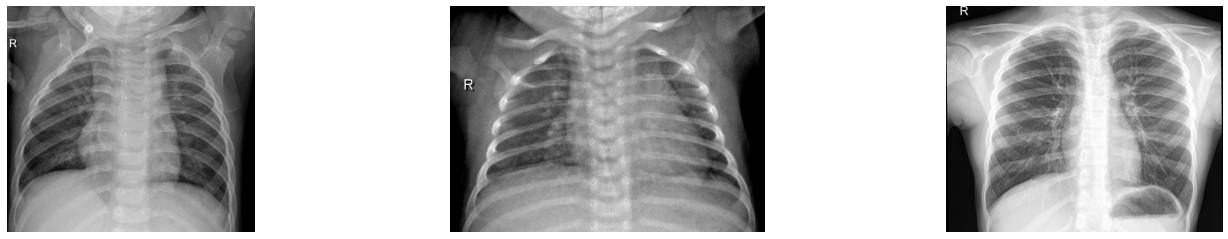

In [ ]:
# Visualising images in for normal class
plt.figure(figsize=(20, 10))

for i in range(3):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(train_NORMAL, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

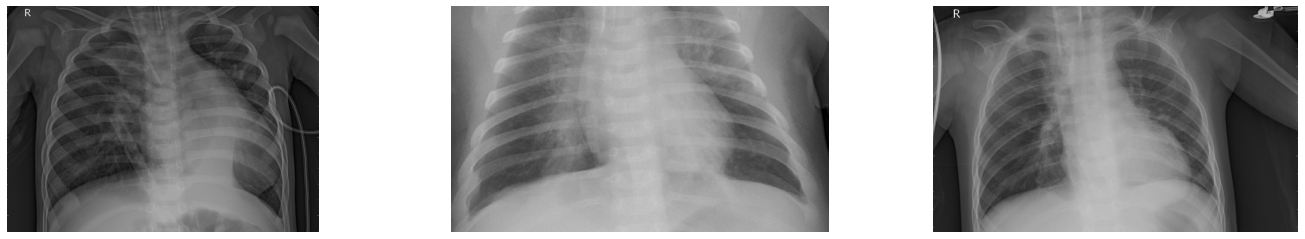

In [ ]:
# Visualising images in for pneumonia class
plt.figure(figsize=(20, 10))

for i in range(3):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(train_PNEUMONIA, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

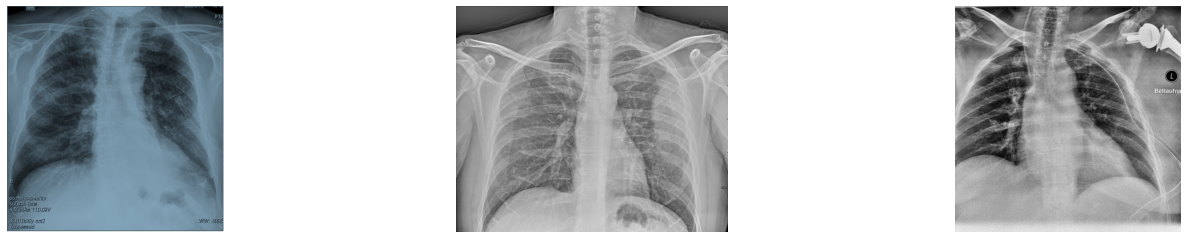

In [ ]:
# Visualising images in for covid19 class
plt.figure(figsize=(20, 10))

for i in range(3):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(train_COVID19, covid19[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

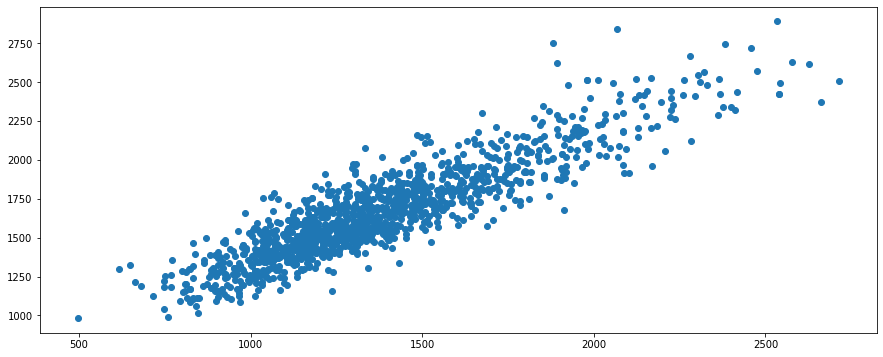

In [ ]:
# Visualising the shapes of images in normal class to have some idea of distribution of shapes of images
dim1 = []
dim2 = []

for image in os.listdir("chest_x-ray_data/Data/train/NORMAL"):
    img = imread("chest_x-ray_data/Data/train/NORMAL" +"/" + image)
    d1, d2, c = img.shape
    dim1.append(d1)
    dim2.append(d2)

plt.figure(figsize = (15, 6))
plt.scatter(dim1, dim2)

Text(0, 0.5, '# Pixels in Image')

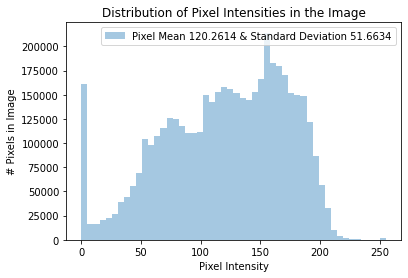

In [ ]:
# Visualisation of distribution of pixels for different pixel intesities before normalisation for normal class
sample_img = plt.imread(os.path.join("chest_x-ray_data/Data/train/NORMAL", normal[0]))

sns.distplot(sample_img.ravel(),
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# Image Preprocessing

In image preprocessing, data augmentation is done in which feature extraction, image re-sizing, normalisation, and data labeling are done. Along with this train data is sub-divided into train and validation data in 80:20 ratio.   

In [ ]:
image_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.2)

In [ ]:
# Train data
train_data = image_generator.flow_from_directory("chest_x-ray_data/Data/train", 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='categorical',
                                            subset="training",
                                            target_size=(320, 320))

Found 4116 images belonging to 3 classes.


In [ ]:
# Validation data
val_data = image_generator.flow_from_directory("chest_x-ray_data/Data/train", 
                                            batch_size=8, 
                                            shuffle=False, 
                                            class_mode='categorical',
                                            subset="validation",
                                            target_size=(320, 320))

Found 1028 images belonging to 3 classes.


In [ ]:
train_data.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [ ]:
# Test data
test_data = image_generator.flow_from_directory("chest_x-ray_data/Data/test", 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='categorical',
                                            target_size=(320, 320))

Found 1288 images belonging to 3 classes.


In [ ]:
test_data.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, ' Optimized Chest X Ray Image')

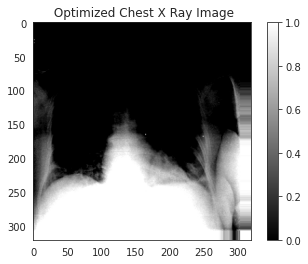

In [ ]:
# Visualisation of image after processing
sns.set_style('white')
generated_image, label = train_data.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title(' Optimized Chest X Ray Image')

Text(0, 0.5, '# Pixels in Image')

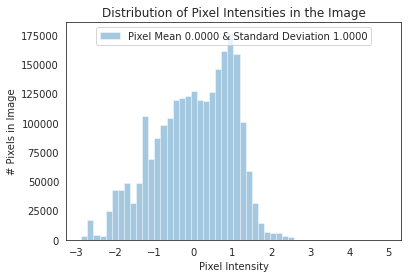

In [ ]:
# Visualisation of distribution of pixels for different pixel intesities after normalisation for all train dataset (Effect of normalisation)
sns.distplot(generated_image.ravel(),
             label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", 
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [ ]:
# Class weights for eacgh class
covid19_wt_0 = len(covid19)/(len(normal) + len(pneumonia) + len(covid19))
normal_wt_1 = len(normal)/(len(normal) + len(pneumonia) + len(covid19))
pneumonia_wt_2 = len(pneumonia)/(len(normal) + len(pneumonia) + len(covid19))

print("covid19 wt: ", covid19_wt_0)
print("normal wt: ", normal_wt_1)

print("pneumonia wt: ", pneumonia_wt_2)

class_weight = {0: covid19_wt_0, 1: normal_wt_1, 2: pneumonia_wt_2}



covid19 wt:  0.08942457231726283
normal wt:  0.24611197511664074
pneumonia wt:  0.6644634525660964


# ResNet50 without training on current dataset

In [ ]:
# Building model
num_classes = 3

base_model1 = Sequential()
base_model1.add(ResNet50(include_top = False, pooling = "avg", weights = "imagenet"))

base_model1.add(Dense(num_classes, activation = "softmax"))

base_model1.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = "accuracy")

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Evaluating model
base_pred1 = base_model1.evaluate(test_data, steps = len(test_data))

print(f"Base model1 test Accuracy: {base_pred1[1] * 100:.2f}%")    

1288/1288 [==============================] - 85s 63ms/step - loss: 1.2390 - accuracy: 0.6638
Base model1 test Accuracy: 66.38%


In [ ]:
# Making predictions with built model
prediction_base_Res = np.argmax(base_model1.predict(test_data, steps=len(test_data), verbose = 1), axis = -1)

1288/1288 [==============================] - 68s 52ms/step


In [ ]:
# Creating report in the form of confusion matrix
def get_report(predictions):
      print(classification_report(test_data.classes,predictions))
      ax = plt.subplot()
      sns.heatmap(confusion_matrix(test_data.classes,predictions), annot = True, ax = ax)
      ax.set_xlabel("Predicted labels")
      ax.set_ylabel("True labels")
      ax.set_title("Confusion matrix")
      ax.xaxis.set_ticklabels(["COVID19", "NORMAL", "PNEUMONIA"])
      ax.yaxis.set_ticklabels(["COVID19", "NORMAL", "PNEUMONIA"])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33      0.27      1288
weighted avg       0.44      0.66      0.53      1288



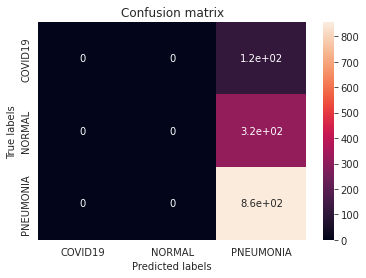

In [ ]:
# Getting report
get_report(prediction_base_Res)

# VGG16 without training on current dataset

In [ ]:
# Building model
num_classes = 3

base_model2 = Sequential()
base_model2.add(VGG16(include_top = False, pooling = "avg", weights = "imagenet"))

base_model2.add(Dense(num_classes, activation = "softmax"))

base_model2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = "accuracy")

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Evaluating model
base_pred2 = base_model2.evaluate(test_data, steps = len(test_data))

print(f"Base model2 test Accuracy: {base_pred2[1] * 100:.2f}%")    

1288/1288 [==============================] - 91s 70ms/step - loss: 0.8778 - accuracy: 0.6638
Base model2 test Accuracy: 66.38%


In [ ]:
# Making predictions with built model
prediction_base_VGG16 = np.argmax(base_model2.predict(test_data, steps=len(test_data), verbose = 1), axis = -1)

1288/1288 [==============================] - 84s 65ms/step


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33      0.27      1288
weighted avg       0.44      0.66      0.53      1288



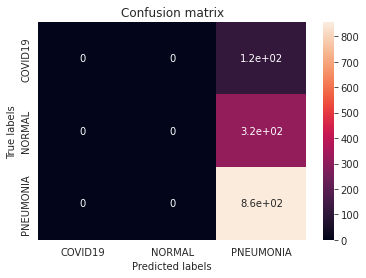

In [ ]:
# Getting report
get_report(prediction_base_VGG16)

# ResNet50 with training on current dataset with single top layer 

In [ ]:
# Bulding  and training model
num_classes = 3

model1 = Sequential()
model1.add(ResNet50(include_top = False, pooling = "avg", weights = "imagenet"))

model1.add(Dense(num_classes, activation = "softmax"))
model1.layers[0].trainable = False

model1.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = "accuracy")

result1 = model1.fit_generator(train_data, steps_per_epoch = len(train_data), validation_data = val_data, validation_steps= len(val_data), epochs = 10)       

94781440/94765736 [==============================] - 2s 0us/step
Epoch 1/10
515/515 [==============================] - 285s 539ms/step - loss: 0.3049 - accuracy: 0.8780 - val_loss: 5.0707 - val_accuracy: 0.0982
Epoch 2/10
515/515 [==============================] - 268s 522ms/step - loss: 0.2094 - accuracy: 0.9215 - val_loss: 1.5933 - val_accuracy: 0.4387
Epoch 3/10
515/515 [==============================] - 267s 520ms/step - loss: 0.2024 - accuracy: 0.9252 - val_loss: 0.3891 - val_accuracy: 0.8599
Epoch 4/10
515/515 [==============================] - 271s 527ms/step - loss: 0.1866 - accuracy: 0.9295 - val_loss: 0.4389 - val_accuracy: 0.8473
Epoch 5/10
515/515 [==============================] - 269s 524ms/step - loss: 0.1756 - accuracy: 0.9356 - val_loss: 0.2498 - val_accuracy: 0.9144
Epoch 6/10
515/515 [==============================] - 269s 524ms/step - loss: 0.1621 - accuracy: 0.9429 - val_loss: 0.2075 - val_accuracy: 0.9319
Epoch 7/10
515/515 [==============================] - 273s 

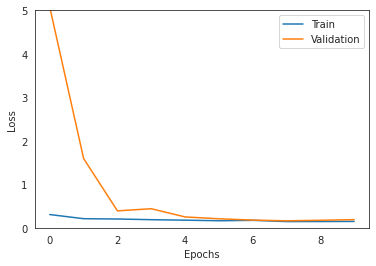

In [ ]:
# Plotting training and validation loss
plt.plot(result1.history["loss"], label = "Train")
plt.plot(result1.history["val_loss"], label = "Validation")
plt.legend(loc = "best")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 5)
plt.show()

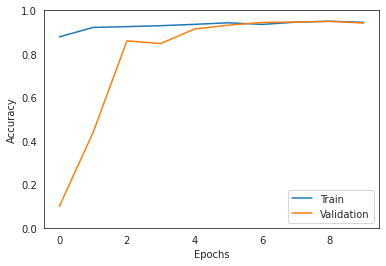

In [ ]:
# Plotting training and validation accuracy
plt.plot(result1.history["accuracy"], label = "Train")
plt.plot(result1.history["val_accuracy"], label = "Validation")
plt.legend(loc = "best")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.show()

In [ ]:
# Evaluating model
pred1 = model1.evaluate(test_data, steps = len(test_data))

print(f"Test Accuracy: {pred1[1] * 100:.2f}%")

1288/1288 [==============================] - 90s 70ms/step - loss: 0.1851 - accuracy: 0.9425
Test Accuracy: 94.25%


In [ ]:
# Making predictions with the trained model 
predictionRes = np.argmax(model1.predict(test_data, steps=len(test_data), verbose = 1), axis = -1)

1288/1288 [==============================] - 74s 56ms/step


In [ ]:
# Creating report in the form of confusion matrix
def get_report(predictions):
      print(classification_report(test_data.classes, predictions))
      ax = plt.subplot()
      sns.heatmap(confusion_matrix(test_data.classes, predictions), annot = True, ax = ax)
      ax.set_xlabel("Predicted labels")
      ax.set_ylabel("True labels")
      ax.set_title("Confusion matrix")
      ax.xaxis.set_ticklabels(["COVID19", "NORMAL", "PNEUMONIA"])
      ax.yaxis.set_ticklabels(["COVID19", "NORMAL", "PNEUMONIA"])


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       116
           1       0.95      0.79      0.87       317
           2       0.93      0.98      0.96       855

    accuracy                           0.94      1288
   macro avg       0.95      0.92      0.93      1288
weighted avg       0.94      0.94      0.94      1288



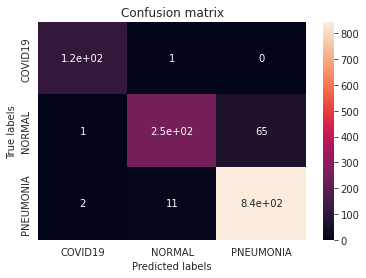

In [ ]:
# Getting report
get_report(predictionRes)

# VGG16 with training on current dataset with single top layer

In [ ]:
# Building and training model
num_classes = 3

model2 = Sequential()
model2.add(VGG16(include_top = False, pooling = "avg", weights = "imagenet"))

model2.add(Dense(num_classes, activation = "softmax"))


model2.layers[0].trainable = False

model2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = "accuracy")

result2 = model2.fit_generator(train_data, steps_per_epoch = len(train_data), validation_data = val_data, validation_steps= len(val_data), epochs = 10)

Epoch 1/10
515/515 [==============================] - 295s 571ms/step - loss: 0.6411 - accuracy: 0.7233 - val_loss: 0.4954 - val_accuracy: 0.8317
Epoch 2/10
515/515 [==============================] - 300s 582ms/step - loss: 0.3995 - accuracy: 0.8537 - val_loss: 0.3839 - val_accuracy: 0.8833
Epoch 3/10
515/515 [==============================] - 306s 594ms/step - loss: 0.3159 - accuracy: 0.8929 - val_loss: 0.3280 - val_accuracy: 0.8901
Epoch 4/10
515/515 [==============================] - 335s 651ms/step - loss: 0.2661 - accuracy: 0.9130 - val_loss: 0.2803 - val_accuracy: 0.9163
Epoch 5/10
515/515 [==============================] - 392s 762ms/step - loss: 0.2415 - accuracy: 0.9247 - val_loss: 0.2756 - val_accuracy: 0.9163
Epoch 6/10
515/515 [==============================] - 293s 570ms/step - loss: 0.2281 - accuracy: 0.9257 - val_loss: 0.2406 - val_accuracy: 0.9329
Epoch 7/10
515/515 [==============================] - 288s 560ms/step - loss: 0.2114 - accuracy: 0.9274 - val_loss: 0.2389 -

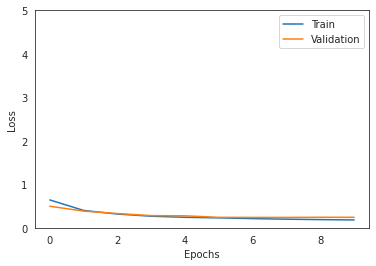

In [ ]:
# Plotting training and validation loss
plt.plot(result2.history["loss"], label = "Train")
plt.plot(result2.history["val_loss"], label = "Validation")
plt.legend(loc = "best")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 5)
plt.show()

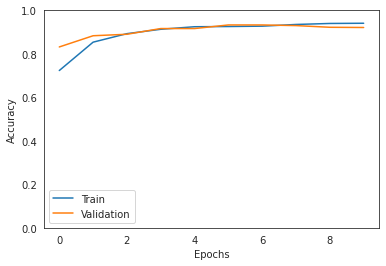

In [ ]:
# Plotting training and validation accuracy
plt.plot(result2.history["accuracy"], label = "Train")
plt.plot(result2.history["val_accuracy"], label = "Validation")
plt.legend(loc = "best")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.show()

In [ ]:
# Evaluating model
pred2 = model2.evaluate(test_data, steps = len(test_data))

print(f"Test Accuracy: {pred2[1] * 100:.2f}%")

1288/1288 [==============================] - 89s 69ms/step - loss: 0.2329 - accuracy: 0.9208
Test Accuracy: 92.08%


In [ ]:
# Making predictions with the trained model
predictionVGG16 = np.argmax(model2.predict(test_data, steps=len(test_data), verbose = 1), axis = -1)

1288/1288 [==============================] - 75s 58ms/step


              precision    recall  f1-score   support

           0       0.88      0.78      0.83       116
           1       0.88      0.75      0.81       317
           2       0.90      0.96      0.93       855

    accuracy                           0.90      1288
   macro avg       0.89      0.83      0.86      1288
weighted avg       0.89      0.90      0.89      1288



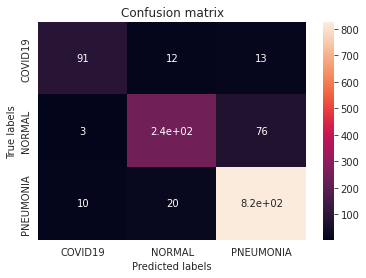

In [ ]:
# Getting report
get_report(predictionVGG16)

# Proposed ResNet50 model with 2 top layers with 16 & 3 neurons and with 1 dropout layer with value 0.2

In [ ]:
# Building  and training the model
num_classes = 3

model = Sequential()
model.add(ResNet50(include_top = False, pooling = "avg", weights = "imagenet"))

model.add(Dense(16, activation = "relu"))
keras.layers.Dropout(0.2)
model.add(Dense(num_classes, activation = "softmax"))
model.layers[0].trainable = False

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = "accuracy")

result = model.fit_generator(train_data, steps_per_epoch = len(train_data), validation_data = val_data, validation_steps= len(val_data), epochs = 10) 

Epoch 1/10
515/515 [==============================] - 226s 433ms/step - loss: 0.3064 - accuracy: 0.8817 - val_loss: 4.3788 - val_accuracy: 0.0905
Epoch 2/10
515/515 [==============================] - 218s 424ms/step - loss: 0.2168 - accuracy: 0.9162 - val_loss: 2.2354 - val_accuracy: 0.3405
Epoch 3/10
515/515 [==============================] - 219s 426ms/step - loss: 0.2067 - accuracy: 0.9242 - val_loss: 0.4005 - val_accuracy: 0.8521
Epoch 4/10
515/515 [==============================] - 220s 428ms/step - loss: 0.1676 - accuracy: 0.9337 - val_loss: 0.1529 - val_accuracy: 0.9533
Epoch 5/10
515/515 [==============================] - 220s 427ms/step - loss: 0.1703 - accuracy: 0.9390 - val_loss: 0.2547 - val_accuracy: 0.9056
Epoch 6/10
515/515 [==============================] - 219s 426ms/step - loss: 0.1599 - accuracy: 0.9371 - val_loss: 0.1721 - val_accuracy: 0.9504
Epoch 7/10
515/515 [==============================] - 223s 433ms/step - loss: 0.1646 - accuracy: 0.9410 - val_loss: 0.3589 -

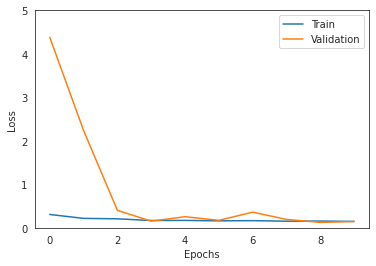

In [ ]:
# Plotting training and validation loss
plt.plot(result.history["loss"], label = "Train")
plt.plot(result.history["val_loss"], label = "Validation")
plt.legend(loc = "best")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 5)
plt.show()

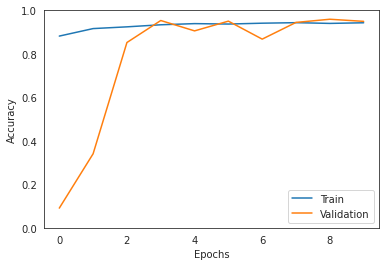

In [ ]:
# Plotting training and validation accuracy
plt.plot(result.history["accuracy"], label = "Train")
plt.plot(result.history["val_accuracy"], label = "Validation")
plt.legend(loc = "best")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.show()

In [ ]:
# Evalating the model
pred = model.evaluate(test_data, steps = len(test_data))

print(f"Test Accuracy: {pred[1] * 100:.2f}%")

1288/1288 [==============================] - 64s 49ms/step - loss: 0.1454 - accuracy: 0.9472
Test Accuracy: 94.72%


In [ ]:
# Making predictions with the trained model
prediction_ResNet50 = np.argmax(model.predict(test_data, steps=len(test_data), verbose = 1), axis = -1)

1288/1288 [==============================] - 58s 44ms/step


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       116
           1       0.93      0.90      0.91       317
           2       0.96      0.97      0.97       855

    accuracy                           0.96      1288
   macro avg       0.96      0.95      0.96      1288
weighted avg       0.96      0.96      0.96      1288



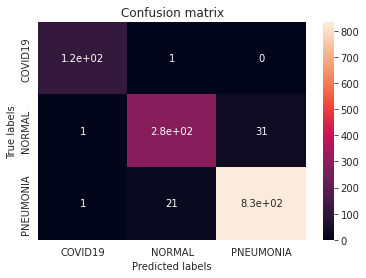

In [ ]:
# Getting report
get_report(prediction_ResNet50)

# Proposed ResNet50 model with 2 top layers with 8 & 3 neurons and with 1 dropout layer with value 0.2

In [ ]:
# Building and training the model
num_classes = 3

final_model = Sequential()
final_model.add(ResNet50(include_top = False, pooling = "avg", weights = "imagenet"))

final_model.add(Dense(8, activation = "relu"))
keras.layers.Dropout(0.2)
final_model.add(Dense(num_classes, activation = "softmax"))
final_model.layers[0].trainable = False

final_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = "accuracy")

final_result = final_model.fit_generator(train_data, steps_per_epoch = len(train_data), validation_data = val_data, validation_steps= len(val_data), epochs = 10) 

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
515/515 [==============================] - 282s 536ms/step - loss: 0.3937 - accuracy: 0.8343 - val_loss: 0.9322 - val_accuracy: 0.6586
Epoch 2/10
515/515 [==============================] - 271s 526ms/step - loss: 0.2814 - accuracy: 0.9023 - val_loss: 0.5978 - val_accuracy: 0.7665
Epoch 3/10
515/515 [==============================] - 261s 508ms/step - loss: 0.2432 - accuracy: 0.9181 - val_loss: 0.3425 - val_accuracy: 0.8755
Epoch 4/10
515/515 [==============================] - 259s 504ms/step - loss: 0.2240 - accuracy: 0.9276 - val_loss: 0.1922 - val_accuracy: 0.9514
Epoch 5/10
515/515 [==============================] - 257s 499ms/step - loss: 0.2127 - accuracy: 0.9327 - val_loss: 0.3647 - val_accuracy: 0.8765
Epoch 6/10
515/515 [==============================] - 255s 497ms/step - loss: 0.1705 - accuracy: 0.9417 - val_loss: 0.2540 - val_accuracy: 0.9115
Epoch 7/10
515/515 [==============================] - 260s 

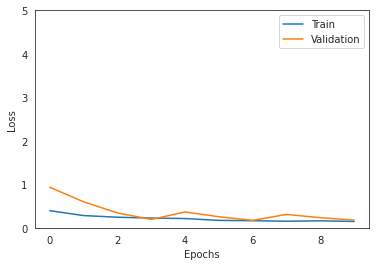

In [ ]:
# Plotting training and validation loss
plt.plot(final_result.history["loss"], label = "Train")
plt.plot(final_result.history["val_loss"], label = "Validation")
plt.legend(loc = "best")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 5)
plt.show()

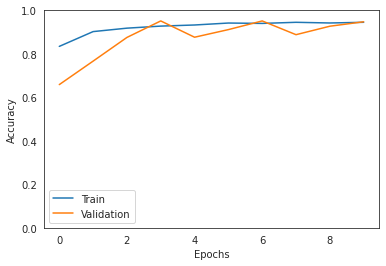

In [ ]:
# Plotting training and validation accuracy
plt.plot(final_result.history["accuracy"], label = "Train")
plt.plot(final_result.history["val_accuracy"], label = "Validation")
plt.legend(loc = "best")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.show()

In [ ]:
# Evaluating model
pred = final_model.evaluate(test_data, steps = len(test_data))

print(f"Test Accuracy: {pred[1] * 100:.2f}%")

1288/1288 [==============================] - 79s 61ms/step - loss: 0.1591 - accuracy: 0.9550
Test Accuracy: 95.50%


In [ ]:
# Making predictions with the trained model
prediction_final = np.argmax(final_model.predict(test_data, steps=len(test_data), verbose = 1), axis = -1)

1288/1288 [==============================] - 67s 52ms/step


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       116
           1       0.93      0.87      0.90       317
           2       0.95      0.97      0.96       855

    accuracy                           0.95      1288
   macro avg       0.95      0.95      0.95      1288
weighted avg       0.95      0.95      0.95      1288



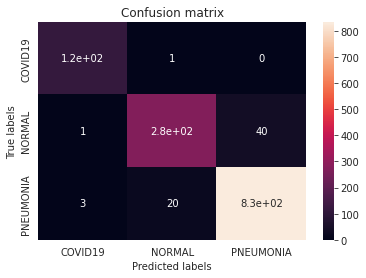

In [ ]:
# Getting report
get_report(prediction_final)